# **HOMEWORK 2 batch version**

In [ ]:
#%history -f output.txt

# **Libraries importation**

In [1]:
import os
import cv2
import scipy
import numpy as np 
import tensorflow as tf
from PIL import Image
from collections import defaultdict
from matplotlib import pyplot as plt 
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('libraries imported')

2023-12-31 11:02:07.959014: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-31 11:02:07.960804: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 11:02:07.988295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 11:02:07.988322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 11:02:07.989062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

libraries imported


# **settings**

In [2]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# **Data Collection**

## **Data Augmentation**

In [3]:
datagen_train = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./96,
    validation_split=0.2
)

datagen_val = ImageDataGenerator(
    rescale=1./96,
    validation_split=0.2,
    horizontal_flip=False,
    vertical_flip=False,
)

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0,
    horizontal_flip=False,
    rescale=1./96,
    fill_mode='nearest',
)

datablanket = ImageDataGenerator(
    rescale=1./96,
)

In [14]:
Train = datablanket.flow_from_directory(
    'train',
    target_size=(96,96),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Val = datablanket.flow_from_directory(
    'train',
    target_size=(96,96),
    batch_size=32,
    class_mode='categorical',
    subset = 'validation',
)

train_labels = []
train_labels = Train.classes
num_classes = Train.num_classes
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)

Found 6369 images belonging to 5 classes.
Found 0 images belonging to 5 classes.


## **Data Load**

### **Load without validation**

In [ ]:
Train = datagen.flow_from_directory(
    'train',
    target_size=(96,96),
    batch_size=32,
    class_mode='categorical'
)

train_labels = []
train_labels = Train.classes
num_classes = Train.num_classes
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)

### **Load with validation**

In [ ]:
Train = datagen_train.flow_from_directory(
    'train',
    target_size=(96,96),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Val = datagen_val.flow_from_directory(
    'train',
    target_size=(96,96),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

train_labels = []
train_labels = Train.classes
num_classes = Train.num_classes
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)

## **Visualization of the dataset**

In [5]:
def visualize_dataset(dataset, num_samples=5):
    for images, labels in dataset:
        num_samples_batch = min(num_samples, len(images))
        fig, ax = plt.subplots(1, num_samples_batch, figsize=(20, 20))
        
        for i in range(num_samples_batch):
            ax[i].imshow((images[i] * 96).astype("uint8"))  # Remove the rescaling here
            ax[i].set_title(f"Label: {labels[i]}")
            ax[i].axis("off")
        
        plt.show()
        break


# num_samples = 5
# for images, labels in Train.take(1):
#     num_samples_batch = min(num_samples, len(images))
#     fig, ax = plt.subplots(1, num_samples_batch, figsize=(20, 20))
#     for i in range(num_samples):
#         ax[i].imshow(images[i].numpy().astype("uint8"))
#         ax[i].set_title(f"Label: {labels[i]}")
#         ax[i].axis("off")
#     plt.show()

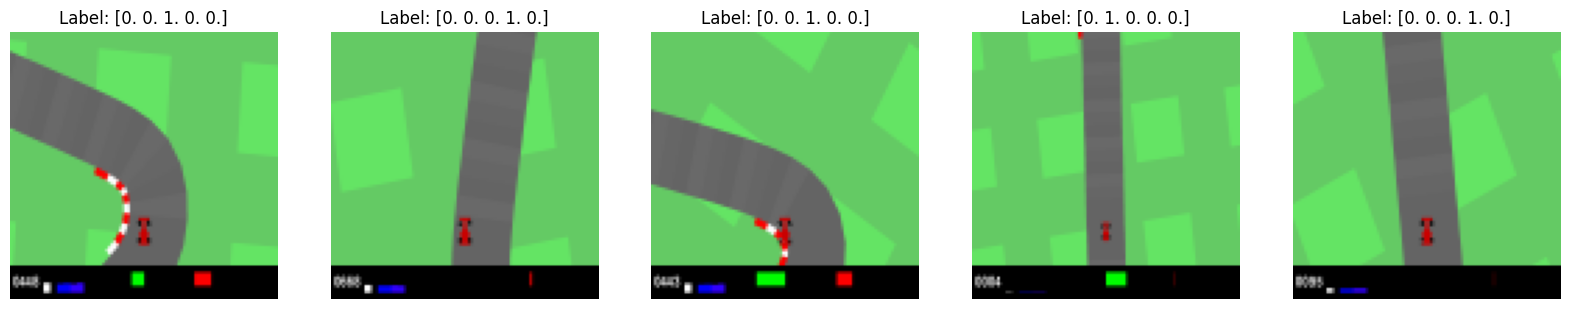

In [6]:
visualize_dataset(Train)

# **Data Preprocessing**
-    Resize images to a common size (e.g., 96x96, as mentioned in the description).
-    Normalize pixel values to a range between 0 and 1.
-    Consider data augmentation techniques (e.g., rotation, flipping) to increase the diversity of your training set.    

# **Model Selection:**
## Model Design
-    Define your own CNN architecture. Start with a simple architecture and gradually increase complexity if needed.
-    Experiment with different layer configurations, activation functions, and filter sizes.
-    Consider incorporating dropout for regularization.

## **Approach 1**
-   First Architecture aims to be narrow and deep
-   Choose appropriate hyperparameters (learning rate, batch size, etc.).


In [ ]:
model = Sequential()

In [ ]:
# Layers
# (3,3) is the pixel selection, 1 is the translation of pixels
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # Dropout layer to reduce overfitting

num_classes = 5
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
optimizer = Adam(learning_rate=0.001)

**Validation ON**

In [ ]:
metrics = ['accuracy', 'val_accuracy']

**Validation OFF**

In [ ]:
metrics = ['accuracy']

In [ ]:
model.compile(optimizer, loss=tf._losses.CategoricalCrossentropy(), metrics=metrics)

In [ ]:
model.summary()

## **Approach 2**
-   Second architecture aims to be wider and less deep
-    Adjust hyperparameters independently of the first approach.


In [7]:
# model = Sequential()

# # feature learning
# model.add(Conv2D(96, (3, 3), strides=(1, 1), activation='relu', input_shape=(96, 96, 3)))
# model.add(MaxPooling2D((2, 2), strides=(1, 1)))
# model.add(BatchNormalization())

# model.add(Conv2D(256, (3, 3), strides=(1, 1), activation='relu'))
# model.add(MaxPooling2D((2, 2), strides=(1, 1)))
# model.add(BatchNormalization())

# model.add(Conv2D(384, (3, 3), strides=(1, 1), activation='relu'))
# model.add(MaxPooling2D((2, 2), strides=(1, 1)))
# model.add(BatchNormalization())

# # classification
# model.add(Flatten())

# model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.0001)))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# num_classes = 5
# model.add(Dense(num_classes, activation='softmax'))

model = Sequential()

# Feature learning
model.add(Conv2D(32, 3, activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization()) 
model.add(Dropout(0.05))

model.add(Conv2D(64, 3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(64, 3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, 3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(1256, 3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.4))

# classification
model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

num_classes = 5
model.add(Dense(num_classes, activation='softmax'))

**Optimizer Adam**

In [8]:
beta_1 = 0.9
beta_2 = 0.999
optimizer = Adam(learning_rate=0.0001, beta_1=beta_1, beta_2=beta_2)
loss = keras.losses.CategoricalCrossentropy()

**Optimizer SGD**

In [ ]:
optimizer=SGD(learning_rate=0.01, momentum=0.9)

**Validation ON**

In [9]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

for layer in model.layers:
    print(f"{layer.name}: Input shape - {layer.input_shape}")

conv2d: Input shape - (None, 96, 96, 3)
max_pooling2d: Input shape - (None, 94, 94, 32)
batch_normalization: Input shape - (None, 47, 47, 32)
dropout: Input shape - (None, 47, 47, 32)
conv2d_1: Input shape - (None, 47, 47, 32)
max_pooling2d_1: Input shape - (None, 45, 45, 64)
batch_normalization_1: Input shape - (None, 22, 22, 64)
dropout_1: Input shape - (None, 22, 22, 64)
conv2d_2: Input shape - (None, 22, 22, 64)
max_pooling2d_2: Input shape - (None, 20, 20, 64)
batch_normalization_2: Input shape - (None, 10, 10, 64)
dropout_2: Input shape - (None, 10, 10, 64)
conv2d_3: Input shape - (None, 10, 10, 64)
max_pooling2d_3: Input shape - (None, 8, 8, 128)
dropout_3: Input shape - (None, 4, 4, 128)
conv2d_4: Input shape - (None, 4, 4, 128)
max_pooling2d_4: Input shape - (None, 2, 2, 1256)
dropout_4: Input shape - (None, 1, 1, 1256)
flatten: Input shape - (None, 1, 1, 1256)
dense: Input shape - (None, 1256)
dropout_5: Input shape - (None, 512)
dense_1: Input shape - (None, 512)


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 47, 47, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0

**Validation OFF**

In [ ]:
model.compile(optimizer, loss=tf._losses.CategoricalCrossentropy(), metrics=['accuracy'])

model.summary()
for layer in model.layers:
    print(layer.output_shape)

## **Hyperparameter Analysis**
-   Choose at least one hyperparameter (e.g., learning rate) and perform a systematic analysis.
-   Train models with different values of the chosen hyperparameter.
-   Compare and visualize the impact on metrics.
-   Consider to apply an early stopping of the training in order to avoid overfitting (see slide 11 pag 55)
-   Consider if to apply Dropout or parameter sharing


# **Model Training**

In [11]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [15]:
class_labels = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(zip(class_labels, class_weights))

### **Fitting with early stopping**

#### **validation OFF**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
hist = model.fit(Train, epochs=20, callbacks=[tensorboard_callback, early_stopping], class_weight=class_weights_dict)

#### **validation ON**

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True)

hist = model.fit(
    Train,
    epochs=20,
    callbacks=[tensorboard_callback, early_stopping], 
    validation_data=Val, 
    validation_steps=Val.samples // Val.batch_size, 
    class_weight=class_weights_dict)

Epoch 1/20
200/200 [==============================] - 21s 98ms/step - loss: 2.7256 - accuracy: 0.3321
Epoch 2/20
200/200 [==============================] - 20s 101ms/step - loss: 2.5263 - accuracy: 0.4390
Epoch 3/20
200/200 [==============================] - 20s 100ms/step - loss: 2.4687 - accuracy: 0.4538
Epoch 4/20
200/200 [==============================] - 20s 100ms/step - loss: 2.3982 - accuracy: 0.4753
Epoch 5/20
200/200 [==============================] - 20s 101ms/step - loss: 2.3260 - accuracy: 0.4903
Epoch 6/20
200/200 [==============================] - 20s 101ms/step - loss: 2.2766 - accuracy: 0.5012
Epoch 7/20
200/200 [==============================] - 20s 102ms/step - loss: 2.2358 - accuracy: 0.5064
Epoch 8/20
200/200 [==============================] - 21s 104ms/step - loss: 2.1849 - accuracy: 0.5158
Epoch 9/20
200/200 [==============================] - 20s 102ms/step - loss: 2.1493 - accuracy: 0.5233
Epoch 10/20
200/200 [==============================] - 21s 104ms/step - lo

### **Fitting without early stopping**

#### **Validation OFF**

In [ ]:
hist = model.fit(Train, epochs=20, callbacks=[tensorboard_callback], class_weight=class_weights_dict)

#### **Validation ON**

In [ ]:
hist = model.fit(Train, epochs=20, callbacks=[tensorboard_callback], validation_data=Val, class_weight=class_weights_dict)

## **Plotting Model Performance**

### **Validation ON**

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(hist.history['loss'], color='teal', label='train_loss')
ax1.plot(hist.history['val_loss'], color='orange', label='val_loss')  # Validation loss
ax1.set_title('Loss')
ax1.legend()

ax2.plot(hist.history['accuracy'], color='teal', label='train_accuracy')
ax2.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')  # Validation accuracy
ax2.set_title('Accuracy')
ax2.legend()

plt.show()

### **Validation OFF**

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(hist.history['loss'], color='teal', label='train_loss')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(hist.history['accuracy'], color='teal', label='train_accuracy')
ax2.set_title('Accuracy')
ax2.legend()

plt.show()

# **Test**

In [ ]:
Test = tf.keras.utils.image_dataset_from_directory('test')
test_iterator = Test.as_numpy_iterator()

all_X_test = []
all_y_test = []

for test_batch in test_iterator:
    X_test_batch, y_test_batch = test_batch
    X_test_normalized_batch = X_test_batch/96.0
    yhat_batch = model.predict(X_test_normalized_batch)
    all_X_test.append(X_test_normalized_batch)
    all_y_test.append(y_test_batch)

X_test_normalized = np.concatenate(all_X_test)
y_test = np.concatenate(all_y_test)

test_iterator = Test.as_numpy_iterator()
Test_batch = next(test_iterator)
X_test, y_test = Test_batch
X_test_normalized = X_test/96.0

In [ ]:
yhat = model.predict(X_test_normalized)

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in Test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_one_hot = tf.keras.utils.to_categorical(y, num_classes=num_classes)
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)                                    

In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

# **Results Visualization and Comparison**
-    Create visualizations (tables, charts, graphs) to present your results.
-    Provide detailed commentary on each visualization, explaining trends or differences observed.

## **Comparison on accuracy between methods**

### **On train and validation**

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.plot(hist.history['accuracy'], color='teal', label='train_accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.suptitle('Model accuracy comparison on train and validation', fontsize=14)
plt.legend(loc="upper left")
plt.show()

### **On Test**

In [ ]:
fig=plt.figure(figsize=(16, 8))
fig = plt.figure(figsize=(16, 8))
plt.plot(acc.result, color='teal', label='test_accuracy') # to edit
plt.suptitle('Model accuracy comparison on test', fontsize=14)
plt.legend(loc="upper left")
plt.show()

## **Fine-Tuning**

## **Deployment**

##valutazioni da fare poi:
- regularization per ridurre l'overfitting?
- il numero di images cambia da classe  a classe (train) vedere se serve prenderne un numero uguale per ciascuna classe
- 